In [14]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary

import random


In [15]:
# train data
X_TRAIN = np.load("Xtrain_Classification_Part1.npy")
Y_TRAIN = np.load("Ytrain_Classification_Part1.npy")

# test data
X_TEST = np.load("Xtest_Classification_Part1.npy")
Y_TEST = np.load("Ytest_Classification_Part1.npy", allow_pickle=True)

Y_TEST = np.array([t[0] == 'M' for t in Y_TEST])


In [16]:
# reshape train data and convert to tensor
X_TRAIN = X_TRAIN.reshape(X_TRAIN.shape[0], 1, 50, 50) / 255
X_TRAIN_tensor = torch.Tensor(X_TRAIN).float()

Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], 1)
Y_TRAIN_tensor = torch.Tensor(Y_TRAIN).float()

# reshape test data and convert to tensor
X_TEST = X_TEST.reshape(X_TEST.shape[0], 1, 50, 50) / 255
X_TEST_tensor = torch.Tensor(X_TRAIN).float()

Y_TEST = Y_TEST.reshape(Y_TEST.shape[0], 1)
Y_TEST_tensor = torch.Tensor(Y_TRAIN).float()

In [17]:
# convert to dataloader
trainSet = TensorDataset(X_TRAIN_tensor, Y_TRAIN_tensor)

trainLoader = DataLoader(trainSet, batch_size=2)

In [18]:
def createGervasio():
    class gervasio(nn.Module):
        def __init__(self) -> None:
            super().__init__()

            self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=1, padding=1)
            size = np.floor((np.floor((50 + 2 * 1 -4) / 1) + 1) / 2)

            self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1)
            size = np.floor((np.floor((size + 2 * 1 - 4) / 1) + 1) / 2)

            expectSize = np.floor((size + 2 * 0 - 1) / 1) + 1
            expectSize = 64 * int(expectSize ** 2)

            self.fc1 = nn.Linear(expectSize, 128)

            self.out = nn.Linear(128, 1)

        def forward(self, x):
            x = F.relu(F.avg_pool2d(self.conv1(x), 2))

            x = F.relu(F.avg_pool2d(self.conv2(x), 2))

            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))

            x = F.relu(self.fc1(x))

            x = torch.sigmoid(self.out(x))

            return x

    # criar o gervasio
    Gervasio = gervasio()

    # loss func
    lossF = nn.BCELoss()  # binary cross entropy

    optimizer = torch.optim.Adam(Gervasio.parameters(), lr=0.001)

    return Gervasio, lossF, optimizer


In [19]:
def trainGervasio():
    # number of epochs
    numepochs = 10

    # create a new model
    Gervasio, lossfun, optimizer = createGervasio()

    # initialize losses and accuracies
    trainLosses = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    testLosses = torch.zeros(numepochs)
    testAcc = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        Gervasio.train()
        batchAcc = []
        batchLoss = []
        for X, Y in trainLoader:

            # forward pass and loss
            Y_pred = Gervasio(X)
            loss = lossfun(Y_pred, Y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            match = ((Y_pred >= 0.5).float() == Y).float()
            batchAcc.append(match)  # add to list of accuracies

        # now that we've trained through the batches, get their average training accuracy
        trainAcc[epochi] = 100*np.mean(np.array(batchAcc[0].tolist()))

        # and get average losses across the batches
        trainLosses[epochi] = np.mean(batchLoss)
        
        

    # function output
    return trainAcc, trainLosses, testAcc, testLosses, Gervasio


In [20]:
Gervasio, _, _ = createGervasio()

summary(Gervasio, (1,50,50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 49, 49]             544
            Conv2d-2           [-1, 64, 23, 23]          32,832
            Linear-3                  [-1, 128]         991,360
            Linear-4                    [-1, 1]             129
Total params: 1,024,865
Trainable params: 1,024,865
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.85
Params size (MB): 3.91
Estimated Total Size (MB): 4.76
----------------------------------------------------------------


In [21]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

trainAcc, trainLosses, testAcc, testLosses, Gervasio = trainGervasio()

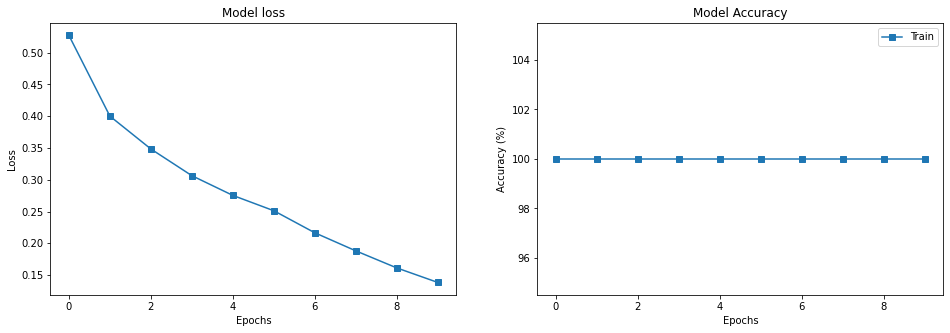

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLosses, "s-", label="Train")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")

ax[1].plot(trainAcc, "s-", label="Train")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Model Accuracy")
ax[1].legend()

plt.show()

In [23]:
Y_pred = Gervasio(X_TEST_tensor)

In [24]:
match = ((Y_pred >= 0.5).float() == Y_TEST_tensor).float()
print(100*np.mean(match.tolist()))

92.07109737248841


female tensor([0.9941], grad_fn=<SelectBackward0>)


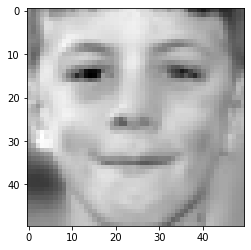

male tensor([0.3703], grad_fn=<SelectBackward0>)


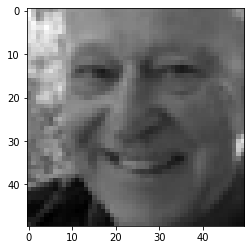

male tensor([0.0016], grad_fn=<SelectBackward0>)


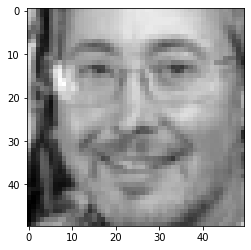

female tensor([0.9982], grad_fn=<SelectBackward0>)


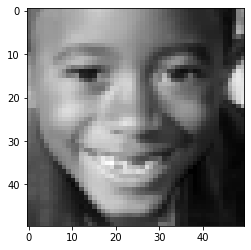

female tensor([1.0000], grad_fn=<SelectBackward0>)


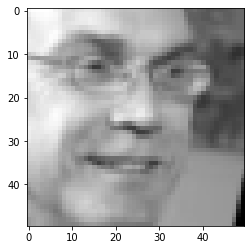

male tensor([0.0375], grad_fn=<SelectBackward0>)


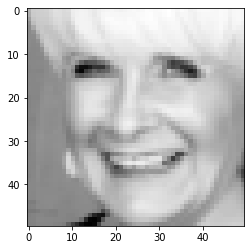

female tensor([0.9975], grad_fn=<SelectBackward0>)


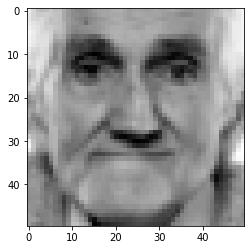

male tensor([0.0002], grad_fn=<SelectBackward0>)


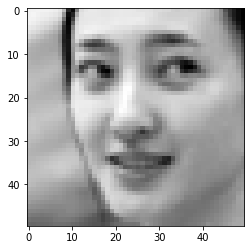

female tensor([1.0000], grad_fn=<SelectBackward0>)


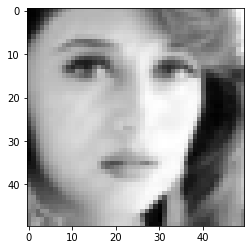

In [25]:
from matplotlib import pyplot as plt

for i in range(1, 10):
  if Y_pred[i] >= 0.5:
    print("female", Y_pred[i])
  else:
    print("male", Y_pred[i])

  plt.imshow(X_TEST[i][0], cmap="gray")
  plt.show()

In [45]:
predictions = np.array((Y_pred >= 0.5).float().tolist())

with open('Y_pred.npy', 'wb') as f:
    np.save(f, predictions)

In [44]:
match = (torch.Tensor(predictions) == Y_TEST_tensor).float()
print(100*np.mean(match.tolist()))

92.07109737248841
